In [1]:
from pathlib import Path
import sys
relative_path = Path('model')
absolute_path = relative_path.resolve()
sys.path.append(str(absolute_path))

In [17]:
import torch
import pytorch_lightning as pl
from SGVB_SSM_TS_Clustering_Model_ResFlow import SGVB_SSM_TS_Clustering_Model_With_NF
from SL_Toy_Dataset import SL_Toy_Dataset, SL_Sample_Dataset
from torch import optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FormatStrFormatter

In [3]:
base_param_dict_sl = {"input_dim":1,
                      "latent_dim":2,
                      "num_clusters":3,
                      "mode":"sl"}

lstm_param_dict = {"embed_hidden_dim":32,
                   "num_lstm_layers_base":2,
                   "num_lstm_layers_other":1,}

resflow_param_dict_sl = {"num_flow_module":4,
                      "kernel_size":2,
                      "dims" : [2, 32, 32, 32, 32, 2],
                      "bias" : True,
                      "coeff" : 0.9,
                      "n_iterations":None,
                      "tolerance":0.001,
                      "reduce_memory": False
                      }

sl_model_param_dict ={ 
                        "c0" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None},
                        "c1" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None},
                        "c2" : {"sl_a1" : 1,
                                 "sl_a2" : None,
                                 "sl_omega1" : None,
                                 "sl_omega2" : None}
                            }

sl_joint_prob_param_dict={
                        "c0" : {"B" : None},
                        "c1" : {"B" : None},
                        "c2" : {"B" : None}}

trained_weight = "./weights/sl_trained_weight.pth"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
data_arr = np.load("data/sl_data.npz")

dataset = SL_Toy_Dataset(data_arr, alldata=True)
dataloader = DataLoader(dataset, batch_size=45, shuffle=False)

sample_dataset = SL_Sample_Dataset(data_arr)
sample_dataloader = DataLoader(sample_dataset, batch_size=3, shuffle=False)
sample_batch = next(iter(sample_dataloader))

In [11]:
model = SGVB_SSM_TS_Clustering_Model_With_NF(base_param_dict=base_param_dict_sl,
                                                lstm_param_dict=lstm_param_dict,
                                                resflow_param_dict=resflow_param_dict_sl,
                                                model_param_dict=sl_model_param_dict,
                                                joint_prob_param_dict=sl_joint_prob_param_dict,
                                                GPU=torch.cuda.is_available()).to(device)
model(sample_batch["y_obs"].to(device))
model.load_state_dict(torch.load(trained_weight))

<All keys matched successfully>

In [12]:
cluster_pred_list = []
cluster_gt_list = []
for batch in tqdm(dataloader):
    pred = model.lstm_embedder(batch["y_obs"].to(device))
    cluster_pred_list.append(np.argmax(pred["cluster"].cpu().detach().numpy(), axis=1))
    cluster_gt_list.append(batch["cluster"].numpy())
cluster_pred = np.concatenate(cluster_pred_list)
cluster_gt = np.concatenate(cluster_gt_list)

  0%|          | 0/20 [00:00<?, ?it/s]

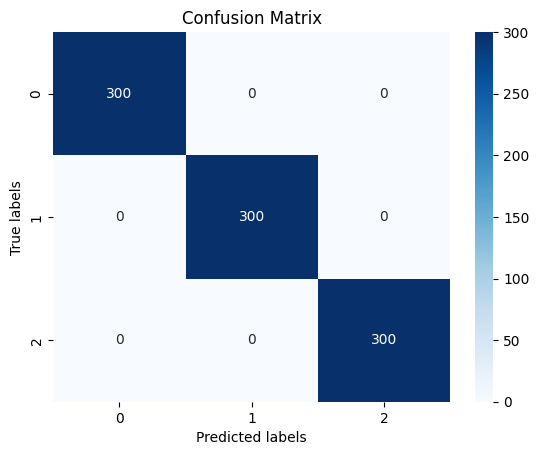

In [13]:
cm = confusion_matrix(cluster_gt, cluster_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
pred = model(sample_batch["y_obs"].to(device))
pred_x = pred["z_logdet"]["z"].to("cpu").detach().numpy()

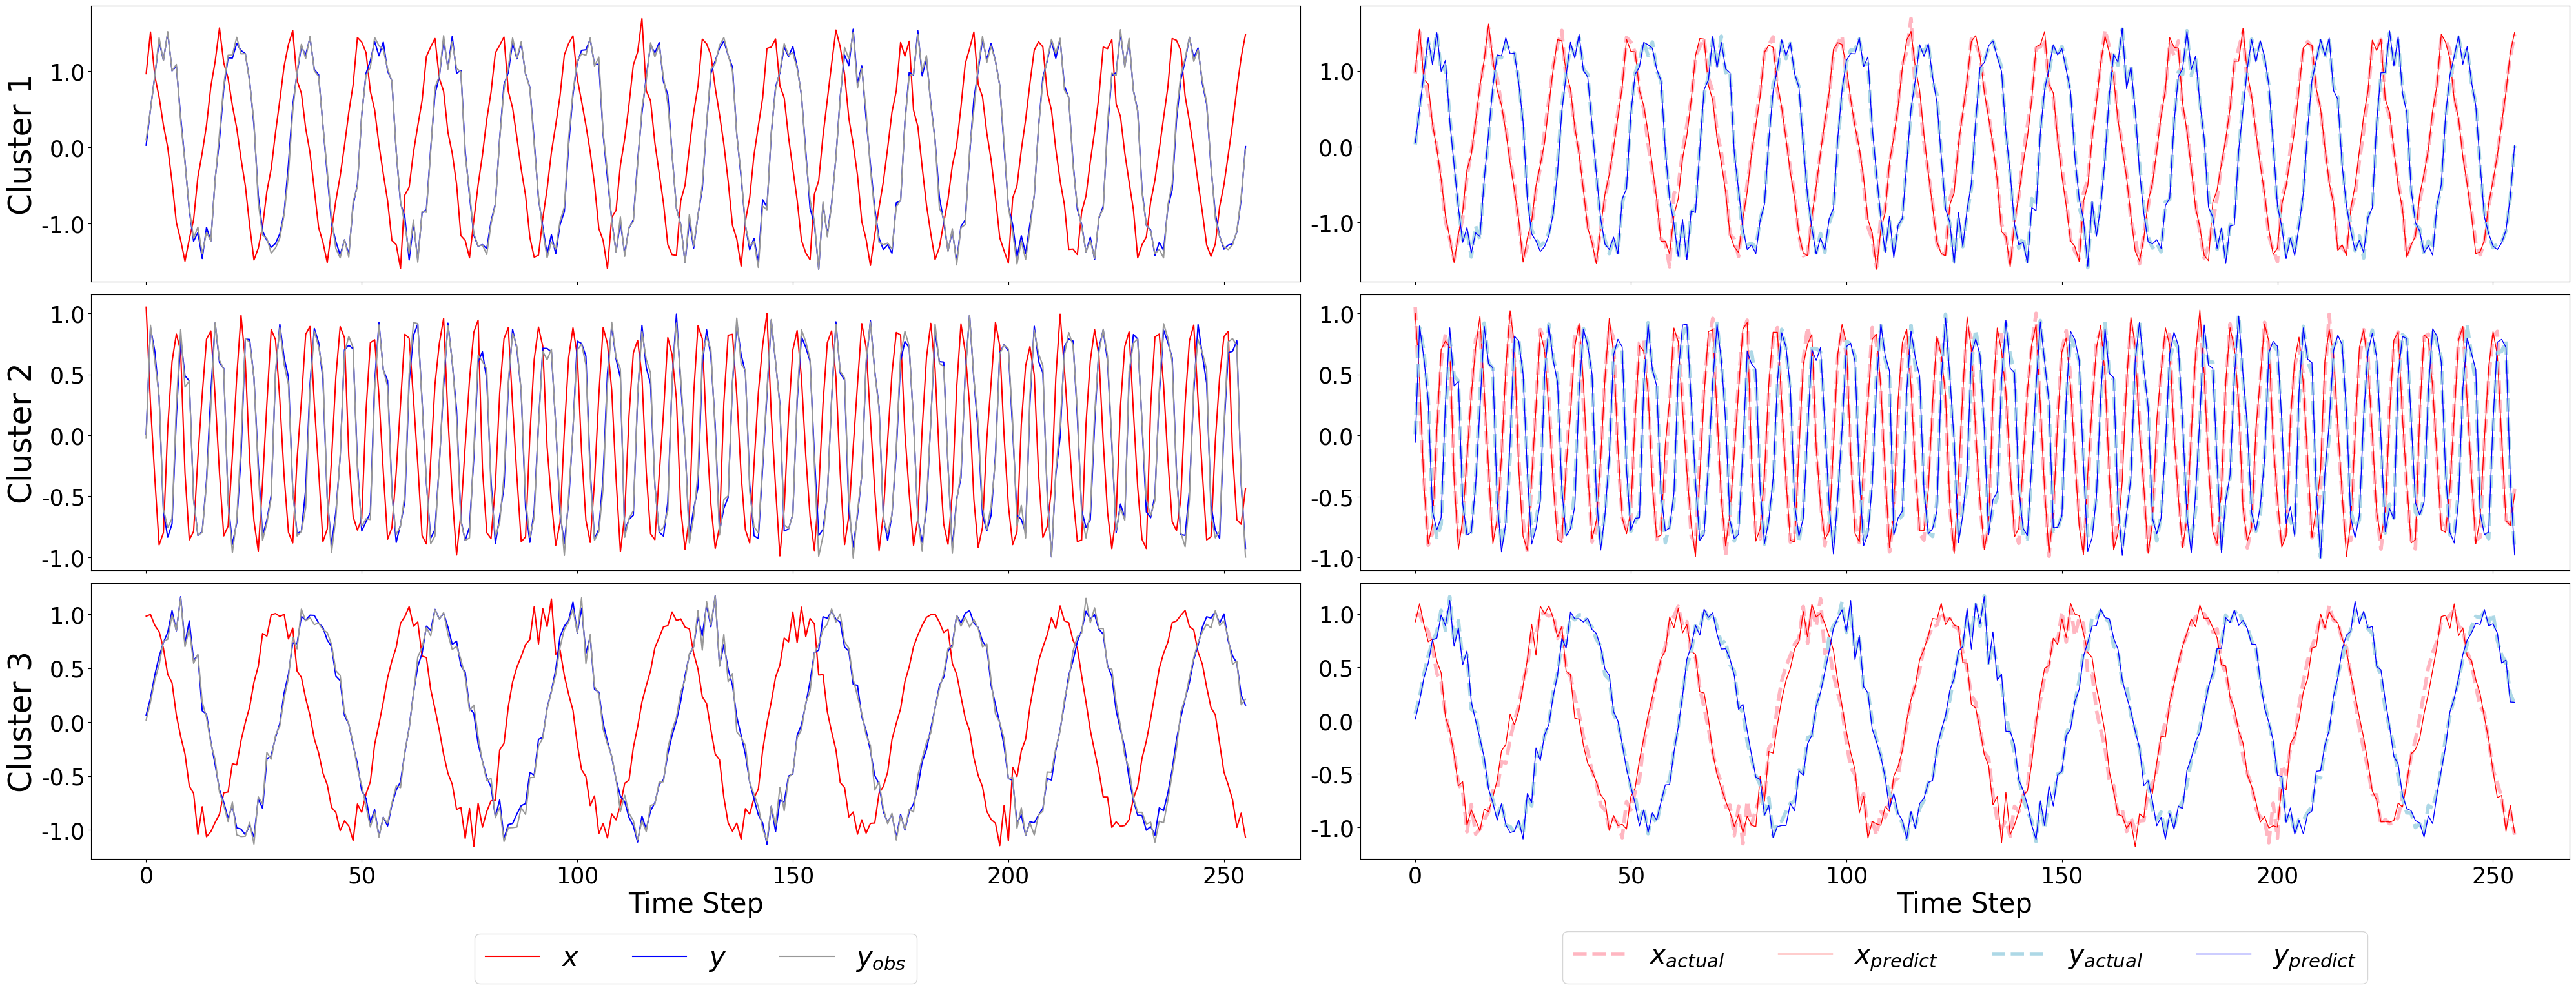

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
# 1行6列のサブプロットを作成
fig, axs = plt.subplots(3, 2, figsize=(40, 15), sharex=True)

# 最初の3つのサブプロットを最初の図の内容で埋める
for i in range(3):
    x = sample_batch["x"][i]
    y = sample_batch["y"][i]
    y_obs = sample_batch["y_obs"][i]
    
    axs[i,0].plot(x, label=r'$x$', c="red")
    axs[i,0].plot(y, label=r'$y$', c="blue")
    axs[i,0].plot(y_obs, label=r'$y_{obs}$', c="0.6")
    axs[i,0].set_ylabel(f"Cluster {i+1}", fontsize=35)
    axs[i,0].tick_params(axis='both', which='major', labelsize=25)
    axs[i,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[i,0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3, fontsize=30)
axs[i,0].set_xlabel("Time Step", fontsize=30)

# 次の3つのサブプロットを2番目の図の内容で埋める
for i in range(3):
    axs[i,1].plot(sample_batch["x"][i], label=r'$x_{actual}$', linestyle="--", c="lightpink", linewidth=4)
    axs[i,1].plot(pred_x[i][i][:,0], label=r'$x_{predict}$', linestyle="-", c="red", linewidth=1)
    axs[i,1].plot(sample_batch["y"][i], label=r'$y_{actual}$', linestyle="--", c="lightblue", linewidth=4)
    axs[i,1].plot(pred_x[i][i][:,1], label=r'$y_{predict}$', linestyle="-", c="blue", linewidth=1)
    #axs[i,1].set_ylabel(f"Cluster {i+1}", fontsize=30)
    axs[i,1].tick_params(axis='both', which='major', labelsize=25)
    axs[i,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[i,1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=4, fontsize=30)
axs[i,1].set_xlabel("Time Step", fontsize=30)

# x軸のラベルとレイアウトの調整
plt.tight_layout()

# 図を表示（または保存）
plt.show()

fig.savefig("sl_all.pdf", format='pdf', bbox_inches='tight')
fig.savefig("sl_all.eps", format='eps', bbox_inches='tight')